<a href="https://www.kaggle.com/code/kansalritu/semantic-segmentation?scriptVersionId=193847455" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

2024-08-24 08:12:15.667785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 08:12:15.667909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 08:12:15.940489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import zipfile
TRAIN_ZIP = '/kaggle/input/data-science-bowl-2018/stage1_train.zip'
TEST_ZIP = '/kaggle/input/data-science-bowl-2018/stage1_test.zip'
# Directory where to extract
TRAIN_PATH = '/kaggle/working/stage1_train/'
TEST_PATH = '/kaggle/working/stage1_test/'

# Unzip the train data
with zipfile.ZipFile(TRAIN_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TRAIN_PATH)

# Unzip the test data
with zipfile.ZipFile(TEST_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TEST_PATH)

print("Extraction complete!")

Extraction complete!


In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1] #gives the folder names
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [6]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [7]:
X_train.shape, Y_train.shape

((670, 128, 128, 3), (670, 128, 128, 1))

In [10]:
seed = 42
np.random.seed = seed

In [11]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # After resizing, ensure the data is in uint8 format and the range [0, 255]
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255)  # Clip values
        img = img.astype(np.uint8)  # Convert to uint8
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask_ = mask_.astype(np.uint8)
        
        mask = np.maximum(mask, mask_)  
    # Convert the mask to boolean
    mask = (mask > 0).astype(bool)    
    Y_train[n] = mask   

100%|██████████| 670/670 [04:05<00:00,  2.72it/s]


In [12]:
X_train[0].shape, Y_train[0].shape

((128, 128, 3), (128, 128, 1))

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


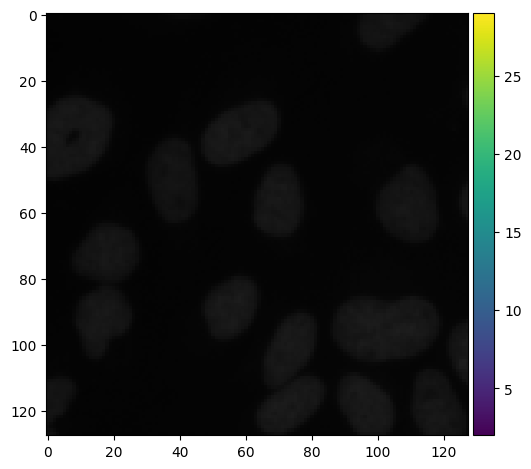

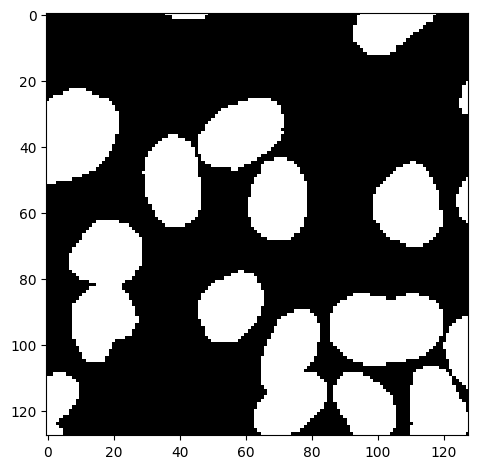

In [13]:
imshow(X_train[0])
plt.show()
imshow(Y_train[0])
plt.show()

In [14]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # print(img.dtype)
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255)  # Clip values
        img = img.astype(np.uint8)  # Convert to uint8
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 47.61it/s]

Done!


166

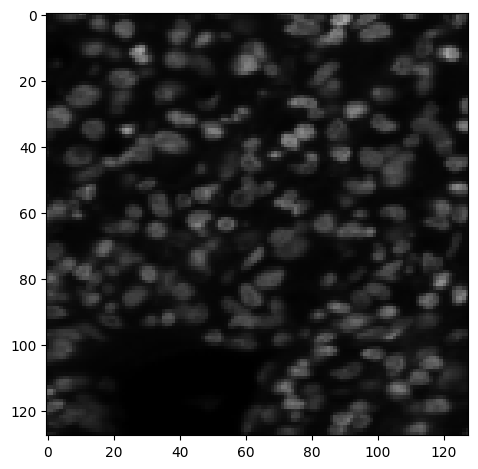

In [15]:
sizes_test[1]
imshow(X_test[1])
X_test[1].max()

16


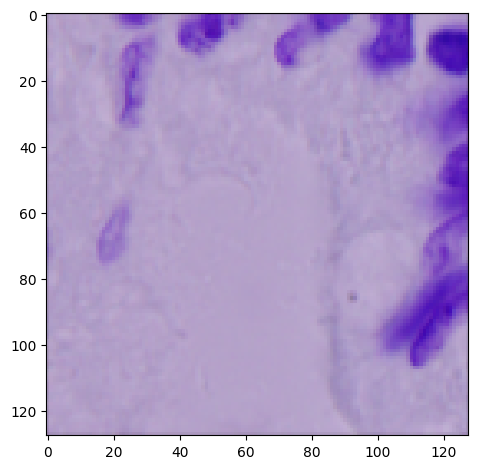

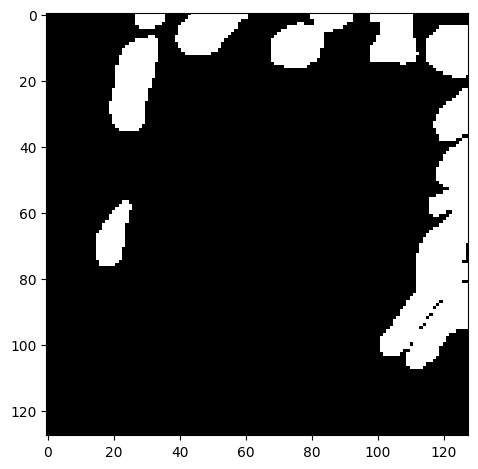

In [16]:
image_x = random.randint(0, len(train_ids))
print(image_x)

imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [72]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_12[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
import datetime

In [74]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Defining callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model_for_nuclei.keras', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')
    tensorboard_callback
]

In [75]:
# Clear any logs from previous runs
!rm -rf /kaggle/working/logs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [76]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=35, callbacks=callbacks)

Epoch 1/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7921 - loss: 0.6123
Epoch 1: val_loss improved from inf to 0.38873, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 521ms/step - accuracy: 0.7924 - loss: 0.6102 - val_accuracy: 0.8078 - val_loss: 0.3887
Epoch 2/35
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8143 - loss: 0.3377
Epoch 2: val_loss improved from 0.38873 to 0.21971, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8155 - loss: 0.3349 - val_accuracy: 0.8887 - val_loss: 0.2197
Epoch 3/35
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9161 - loss: 0.2002
Epoch 3: val_loss improved from 0.21971 to 0.15822, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9167 - loss: 0.1994 - val_accuracy: 0.9422 - val_loss: 0.1582
Epoch 4/35
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9406 - loss: 0.1590
Epoch 4: val_loss improved from 0.15822 

In [77]:
# type(results)
results.history

{'accuracy': [0.8044123649597168,
  0.8395836353302002,
  0.9282402396202087,
  0.9440754055976868,
  0.9508527517318726,
  0.9544060230255127,
  0.9593762159347534,
  0.9617055654525757,
  0.9629095792770386,
  0.96317058801651],
 'loss': [0.5302528142929077,
  0.2847037613391876,
  0.18367412686347961,
  0.14927294850349426,
  0.12967652082443237,
  0.12007033824920654,
  0.10586383938789368,
  0.09878916293382645,
  0.09627535194158554,
  0.0949845090508461],
 'val_accuracy': [0.8078494668006897,
  0.888680100440979,
  0.942193329334259,
  0.9536670446395874,
  0.959409773349762,
  0.9548758864402771,
  0.9634681940078735,
  0.966437041759491,
  0.9615132212638855,
  0.96650630235672],
 'val_loss': [0.38872599601745605,
  0.21970701217651367,
  0.15821854770183563,
  0.1237884908914566,
  0.1101892963051796,
  0.11063261330127716,
  0.0925569236278534,
  0.08573870360851288,
  0.09545326977968216,
  0.08695665001869202]}

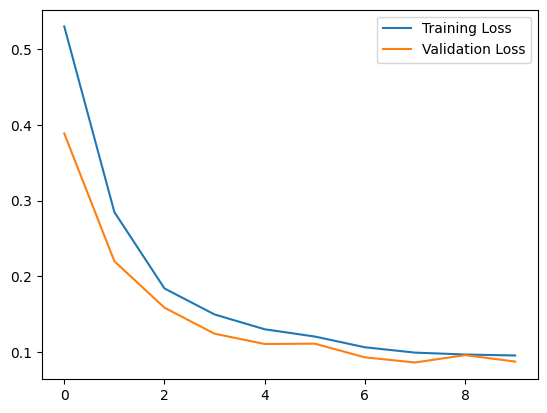

In [78]:
history = results.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

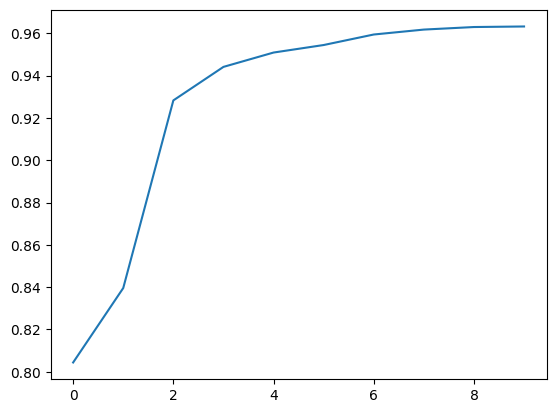

In [79]:
history = results.history
plt.plot(history['accuracy'], label='Accuracy')
plt.show()

In [80]:
model.input_shape

(None, 128, 128, 3)

In [81]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(128, 128, 1)


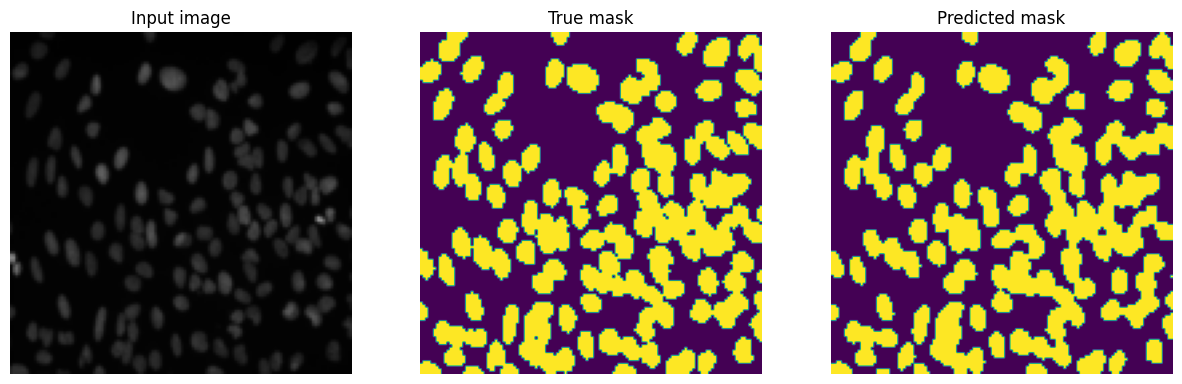

In [91]:
idx = random.randint(0, len(X_train))
true_image = X_train[idx]
true_mask = np.squeeze(Y_train[idx])
# Add batch dimension and then predict
prediction = model.predict(true_image[tf.newaxis, ...])[0]

predicted_mask = (prediction > 0.5).astype(np.uint8)
print(predicted_mask.shape)
display([true_image, true_mask,predicted_mask])

In [89]:
model.save('/kaggle/working/unet.h5')

In [95]:
predicted_masks = model.predict(X_train)
# For binary segmentation, we usually apply a threshold of 0.5
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)

# Now `predicted_masks` is an array of shape (670, 128, 128, 1), similar to `y_train`
print(predicted_masks.shape) 

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step
(670, 128, 128, 1)


In [93]:
# Create directories to save the true and predicted masks
true_masks_folder = '/kaggle/working/true_masks'
predicted_masks_folder = '/kaggle/working/predicted_masks'
os.makedirs(true_masks_folder, exist_ok=True)
os.makedirs(predicted_masks_folder, exist_ok=True)


In [97]:
import shutil
import imageio
# Assuming `true_masks` and `predicted_masks` are numpy arrays of shape (670, 128, 128, 1)
# Iterate through all masks and save them as PNG images
for i in range(len(X_train)):  # Adjust the range based on the number of masks
    # Get the i-th true and predicted mask
    true_mask = np.squeeze(Y_train[i])  # Squeeze to remove the single channel dimension (128, 128)
    predicted_mask = np.squeeze(predicted_masks[i])

    # Create the paths to save the images
    true_mask_save_path = os.path.join(true_masks_folder, f'true_mask_{i}.png')
    predicted_mask_save_path = os.path.join(predicted_masks_folder, f'predicted_mask_{i}.png')

    # Save the true and predicted masks as images
    imageio.imwrite(true_mask_save_path, (true_mask * 255).astype(np.uint8))  # Scale if necessary
    imageio.imwrite(predicted_mask_save_path, (predicted_mask * 255).astype(np.uint8))

print("True and Predicted masks saved in their respective folders.")

True and Predicted masks saved in their respective folders.


In [98]:
# Now create zip archives for both directories
shutil.make_archive('/kaggle/working/true_masks_archive', 'zip', true_masks_folder)
shutil.make_archive('/kaggle/working/predicted_masks_archive', 'zip', predicted_masks_folder)

print("Masks folders zipped successfully.")

Masks folders zipped successfully.
